# GBM asserting correlation and jumps

In [1]:
import pandas as pd  
import numpy as np
from scipy.stats import t, rankdata, norm, poisson, laplace, uniform
import matplotlib.pyplot as plt
from dotenv.main import load_dotenv
load_dotenv(override=True)
import os

In [2]:
def fetch_data_df():
    df = pd.read_csv(
        '../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    return df

In [3]:
returns_df = fetch_data_df()
returns_df.columns = ['RE', 'PE', 'Equity',
                      'IG Bonds', 'GOV Bonds', 'HY Bonds', 'Money']
returns_df = returns_df[['Equity', 'PE', 'RE',
                         'GOV Bonds', 'IG Bonds', 'HY Bonds', 'Money']]

In [4]:
# finding the correlation matrix

correlation_matrix = returns_df.corr()
print(correlation_matrix)

             Equity        PE        RE  GOV Bonds  IG Bonds  HY Bonds  \
Equity     1.000000  0.837673  0.567106  -0.043435 -0.095708  0.464297   
PE         0.837673  1.000000  0.677835  -0.029191 -0.019773  0.579575   
RE         0.567106  0.677835  1.000000   0.083520  0.079361  0.522943   
GOV Bonds -0.043435 -0.029191  0.083520   1.000000  0.616753  0.106941   
IG Bonds  -0.095708 -0.019773  0.079361   0.616753  1.000000  0.357597   
HY Bonds   0.464297  0.579575  0.522943   0.106941  0.357597  1.000000   
Money     -0.024041 -0.042202 -0.041721   0.021083  0.012168 -0.016319   

              Money  
Equity    -0.024041  
PE        -0.042202  
RE        -0.041721  
GOV Bonds  0.021083  
IG Bonds   0.012168  
HY Bonds  -0.016319  
Money      1.000000  


In [5]:
def simulate_gbm_with_jumps(returns_df, correlation_matrix, T=252, dt=1, jump_params=None):
    """
    Simulates Geometric Brownian Motion with Jumps for multiple correlated assets.

    Parameters:
    - returns_df: DataFrame of historical returns (daily percentage change in decimal form).
    - correlation_matrix: Correlation matrix of assets.
    - T: Number of time steps (default 252 for a year).
    - dt: Time step size (default 1 day).
    - jump_params: Dictionary specifying jump intensity (lambda) and jump size distribution per asset.

    Returns:
    - Simulated paths as a DataFrame.
    """
    
    mu = returns_df.mean() 
    sigma = returns_df.std() 

    n_assets = returns_df.shape[1]
    S0 = np.full(n_assets, 100)

    # Cholesky decomposition for correlated Brownian motions
    L = np.linalg.cholesky(correlation_matrix)

    paths = np.zeros((T, n_assets))
    paths[0, :] = S0

    for t in range(1, T):
        # Generate correlated Brownian motions
        Z = np.random.normal(size=n_assets)
        dW = np.dot(L, Z) * np.sqrt(dt)

        # Initialize jump process
        J = np.zeros(n_assets)
        
        if jump_params:
            for i, name in enumerate(returns_df.columns):
                # Poisson-distributed number of jumps
                num_jumps = np.random.poisson(jump_params[name]['lambda'] * dt)
                if num_jumps > 0:
                    # Sample jump size from specified distribution
                    J[i] = np.sum(jump_params[name]['jump_distribution'].rvs(size=num_jumps))
        
        # GBM with jumps formula
        paths[t, :] = paths[t-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW + J)

    return pd.DataFrame(paths, columns=returns_df.columns)


In [6]:
'''jump_params = {
    # Equity (MSCI World) - mostly downward
    0: {'lambda': 0.06, 'jump_distribution': norm(loc=-0.005, scale=0.015)},
    # Private Equity (LPX50) - some upside risk
    1: {'lambda': 0.08, 'jump_distribution': norm(loc=0.002, scale=0.02)},
    # Real Estate (REITs) - rare downward jumps
    2: {'lambda': 0.05, 'jump_distribution': norm(loc=-0.003, scale=0.01)},
    # Gov Bonds - rare negative shocks
    3: {'lambda': 0.02, 'jump_distribution': norm(loc=-0.002, scale=0.005)},
    # IG Bonds - low jump frequency
    4: {'lambda': 0.03, 'jump_distribution': norm(loc=-0.002, scale=0.007)},
    # HY Bonds - riskier, more frequent jumps
    5: {'lambda': 0.06, 'jump_distribution': norm(loc=-0.005, scale=0.02)},
    # Money Market - almost no jumps
    6: {'lambda': 0.005, 'jump_distribution': norm(loc=0, scale=0.002)},
}'''

"jump_params = {\n    # Equity (MSCI World) - mostly downward\n    0: {'lambda': 0.06, 'jump_distribution': norm(loc=-0.005, scale=0.015)},\n    # Private Equity (LPX50) - some upside risk\n    1: {'lambda': 0.08, 'jump_distribution': norm(loc=0.002, scale=0.02)},\n    # Real Estate (REITs) - rare downward jumps\n    2: {'lambda': 0.05, 'jump_distribution': norm(loc=-0.003, scale=0.01)},\n    # Gov Bonds - rare negative shocks\n    3: {'lambda': 0.02, 'jump_distribution': norm(loc=-0.002, scale=0.005)},\n    # IG Bonds - low jump frequency\n    4: {'lambda': 0.03, 'jump_distribution': norm(loc=-0.002, scale=0.007)},\n    # HY Bonds - riskier, more frequent jumps\n    5: {'lambda': 0.06, 'jump_distribution': norm(loc=-0.005, scale=0.02)},\n    # Money Market - almost no jumps\n    6: {'lambda': 0.005, 'jump_distribution': norm(loc=0, scale=0.002)},\n}"

Try to find params from historical data

In [7]:
# Set threshold for identifying jumps (3-sigma rule)
k = 3

mu_est = returns_df.mean()
sigma_est = returns_df.std()

# Identify jumps: Returns beyond k * sigma from the mean
jumps_df = (returns_df - mu_est).abs() > (k * sigma_est)

# Estimate jump intensity (λ) as the fraction of days with jumps
lambda_est = jumps_df.mean()

# Extract jump sizes
jump_sizes = {asset: returns_df[asset][jumps_df[asset]]
              for asset in returns_df.columns}

# Fit normal distribution to jump sizes
jump_params_est = {}
for asset, jumps in jump_sizes.items():
    if len(jumps) > 1:  # Ensure there are enough jumps to estimate
        loc, scale = norm.fit(jumps)  # Fit normal distribution
    else:
        loc, scale = 0, sigma_est[asset]  # Default if no jumps detected
        print(f'No jumps detected for {asset}. Using default parameters.')

    jump_params_est[asset] = {'lambda': lambda_est[asset],
                              'jump_distribution': norm(loc=loc, scale=scale)}

In [8]:
for asset, params in jump_params_est.items():
    print(f'{asset}: λ = {params["lambda"]:.4f}, μ = {params["jump_distribution"].mean():.4f}, σ = {params["jump_distribution"].std():.5f}')


Equity: λ = 0.0156, μ = -0.0109, σ = 0.04461
PE: λ = 0.0169, μ = -0.0145, σ = 0.05901
RE: λ = 0.0176, μ = -0.0059, σ = 0.05408
GOV Bonds: λ = 0.0152, μ = 0.0011, σ = 0.01192
IG Bonds: λ = 0.0118, μ = -0.0025, σ = 0.01070
HY Bonds: λ = 0.0167, μ = -0.0038, σ = 0.01683
Money: λ = 0.0375, μ = 0.0003, σ = 0.00002


In [9]:
jump_params_est

{'Equity': {'lambda': np.float64(0.015628345108113895),
  'jump_distribution': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d510df1730>},
 'PE': {'lambda': np.float64(0.016912866623849283),
  'jump_distribution': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d510e11fd0>},
 'RE': {'lambda': np.float64(0.017555127381716978),
  'jump_distribution': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d510edcc50>},
 'GOV Bonds': {'lambda': np.float64(0.01520017126953543),
  'jump_distribution': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d510edcd40>},
 'IG Bonds': {'lambda': np.float64(0.011774780560907729),
  'jump_distribution': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d510edce60>},
 'HY Bonds': {'lambda': np.float64(0.016698779704560053),
  'jump_distribution': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d510edcf80>},
 'Money': {'lambda': np.float64(0.0374652108756155),
  'jump_distributio

In [10]:
n_realizations = 10000
simulated_results = {i: simulate_gbm_with_jumps(returns_df, correlation_matrix, jump_params=jump_params_est) for i in range(n_realizations)}

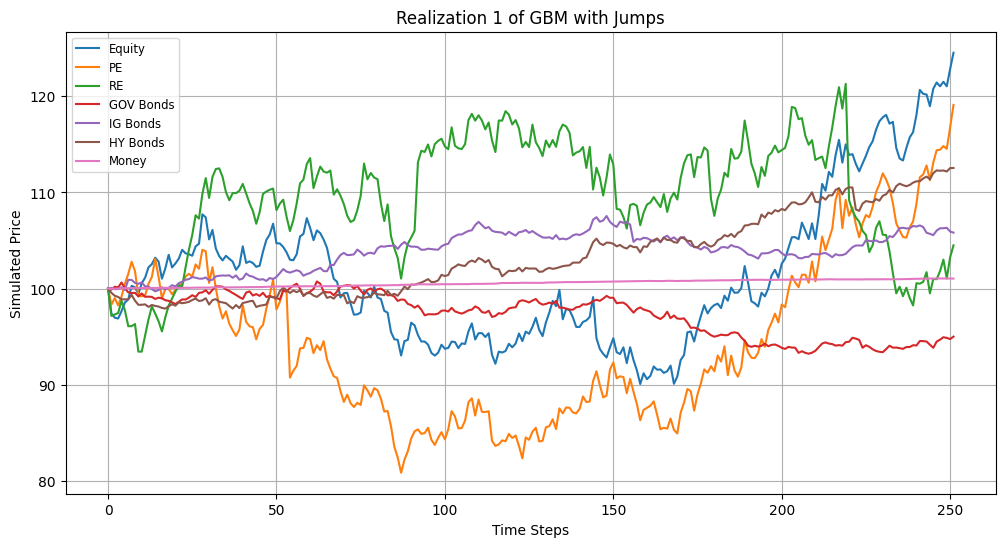

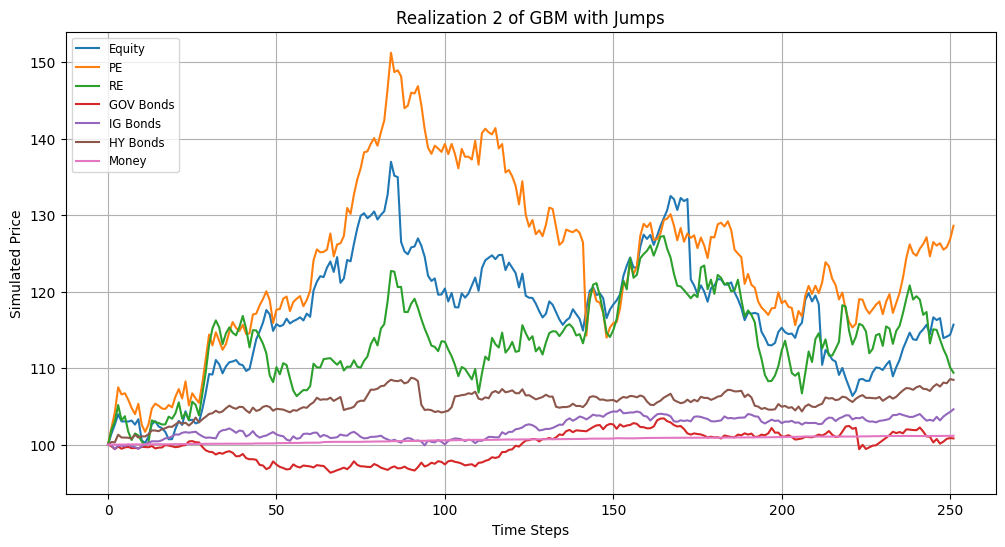

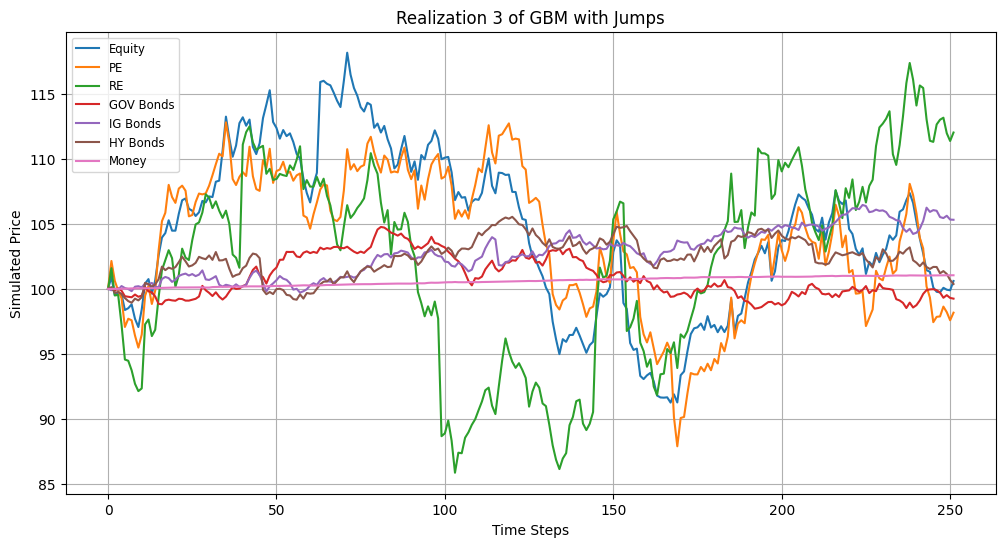

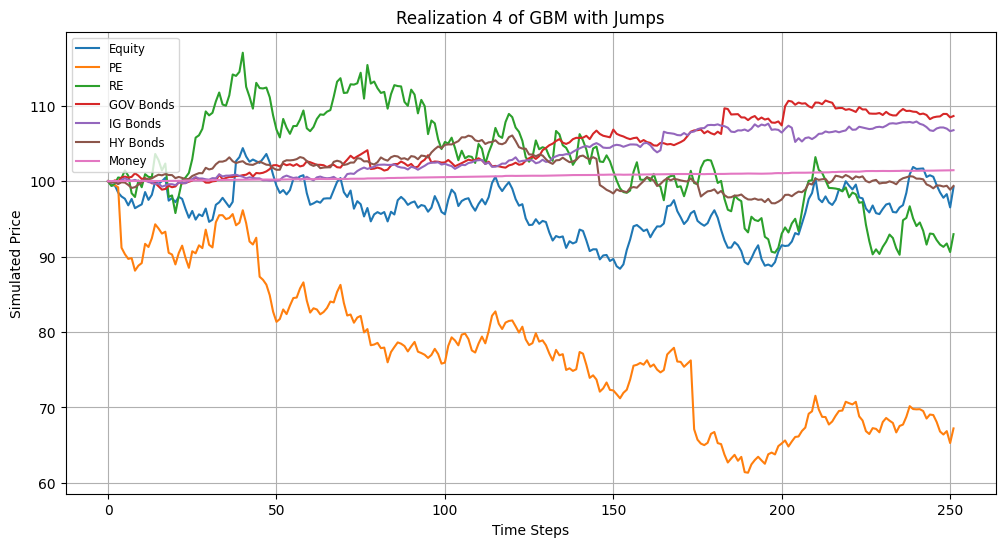

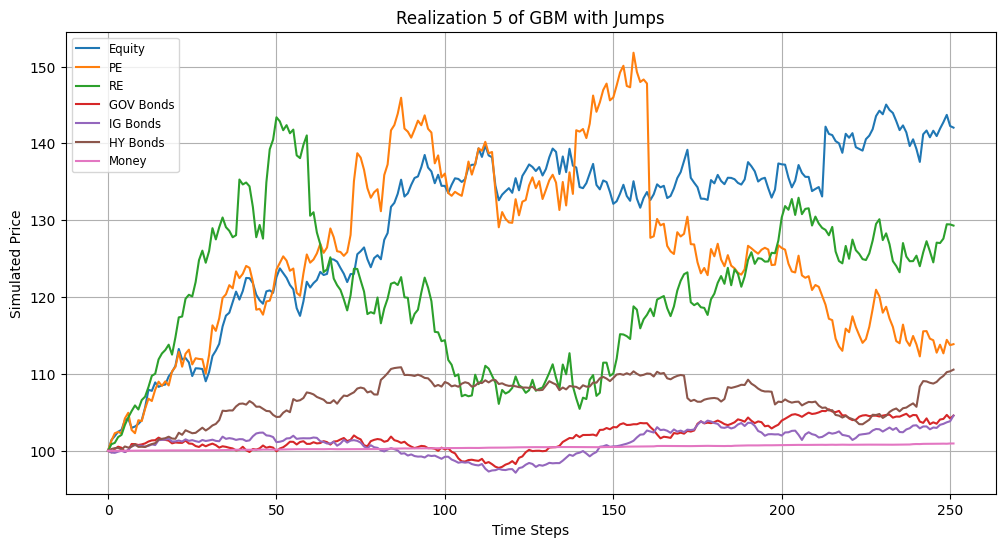

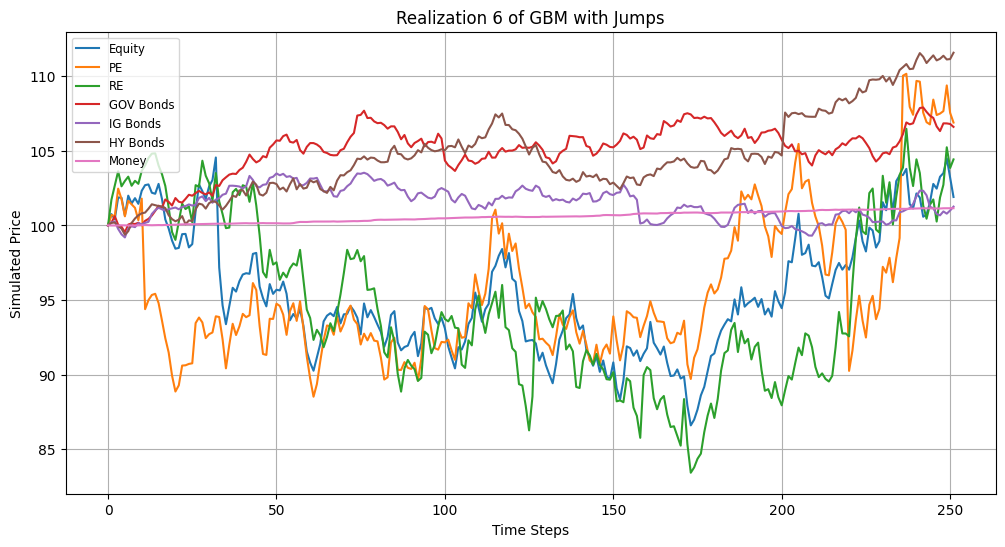

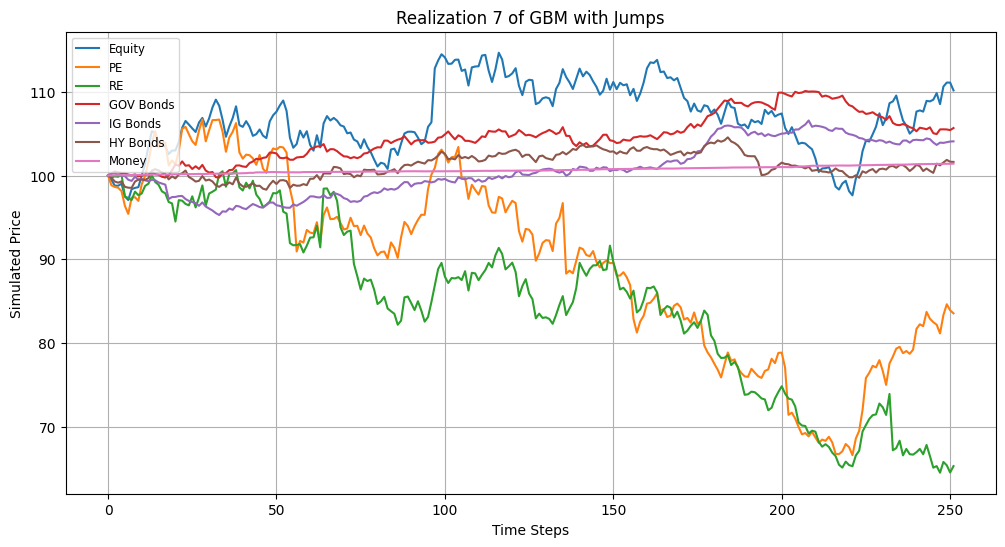

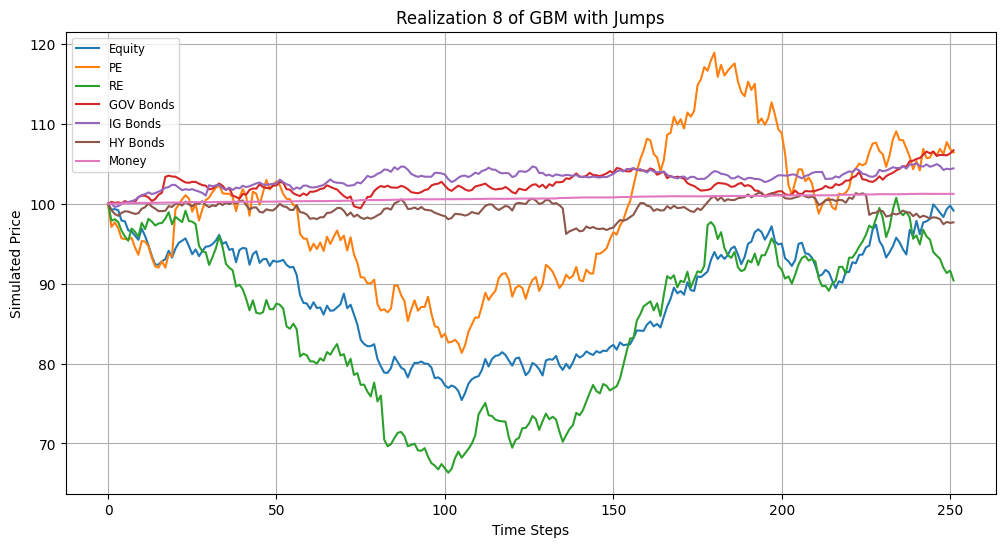

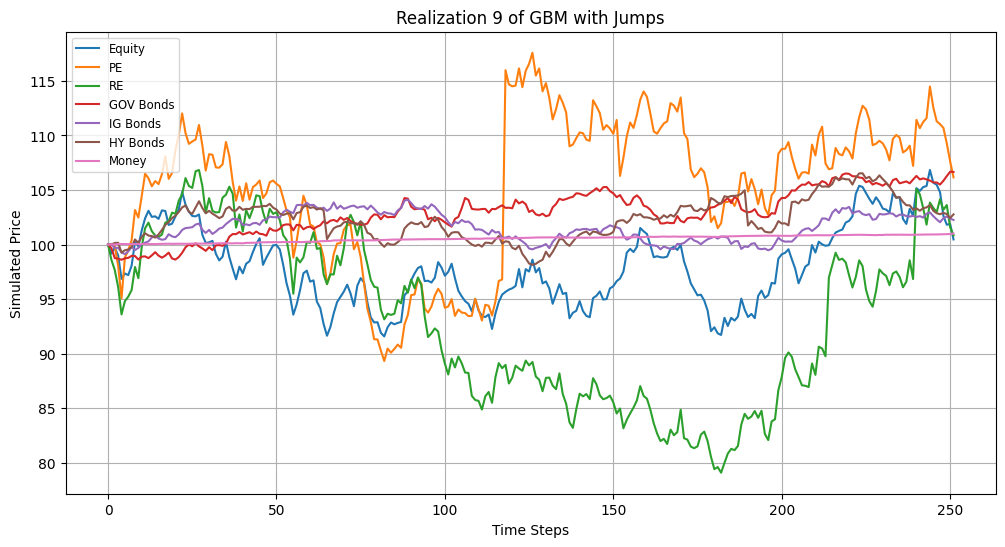

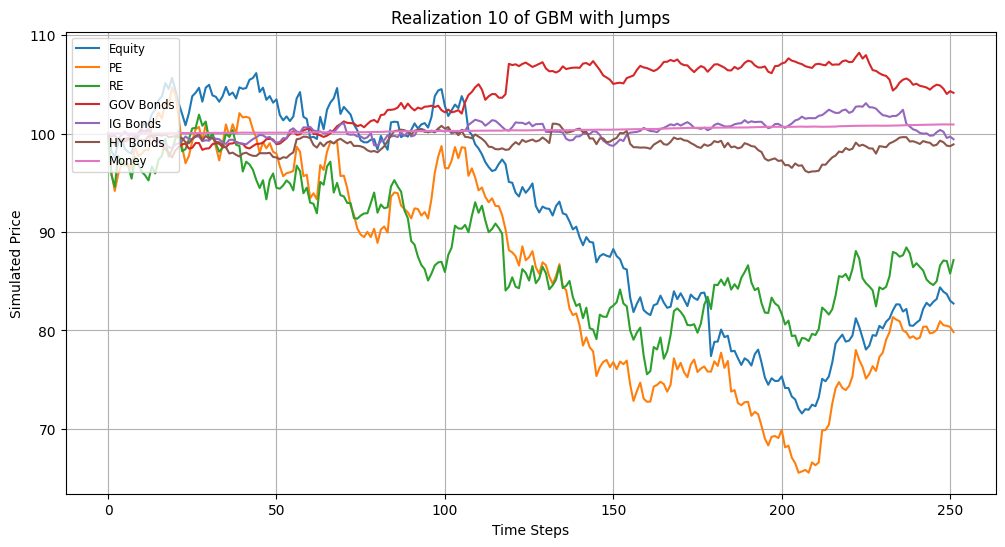

In [11]:
for i in range(10):
    plt.figure(figsize=(12, 6))
    for asset in returns_df.columns:
        plt.plot(simulated_results[i].index,
                 simulated_results[i][asset], label=asset)

    plt.xlabel("Time Steps")
    plt.ylabel("Simulated Price")
    plt.title(f"Realization {i+1} of GBM with Jumps")
    plt.legend(loc="upper left", fontsize="small")
    plt.grid(True)
    plt.show()

Distributions

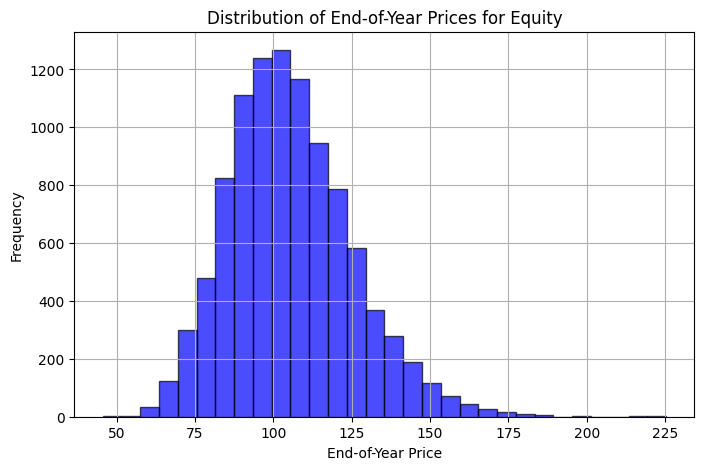

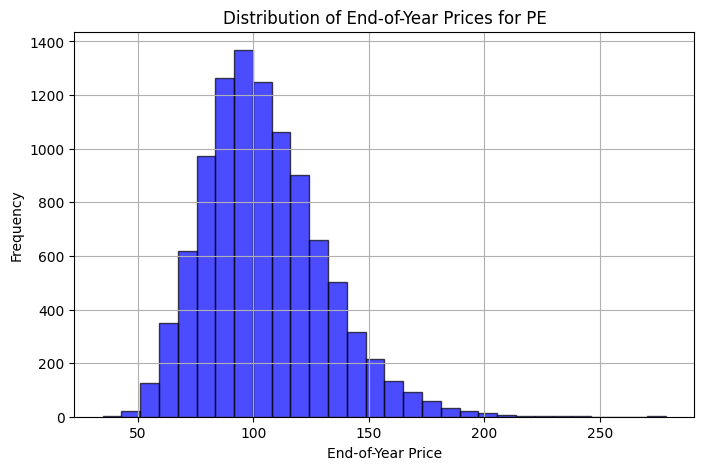

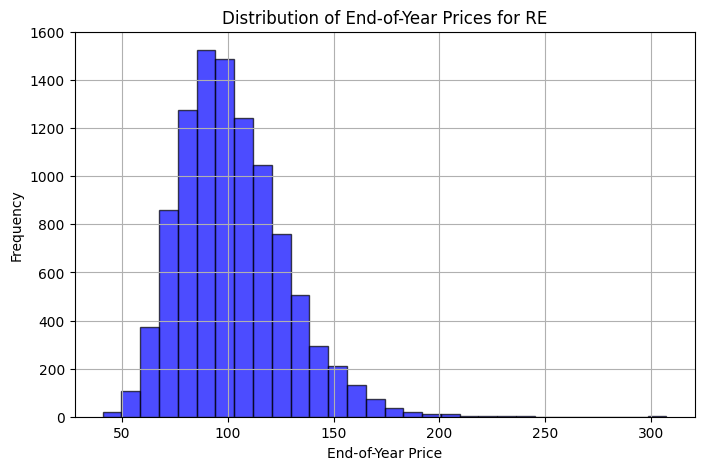

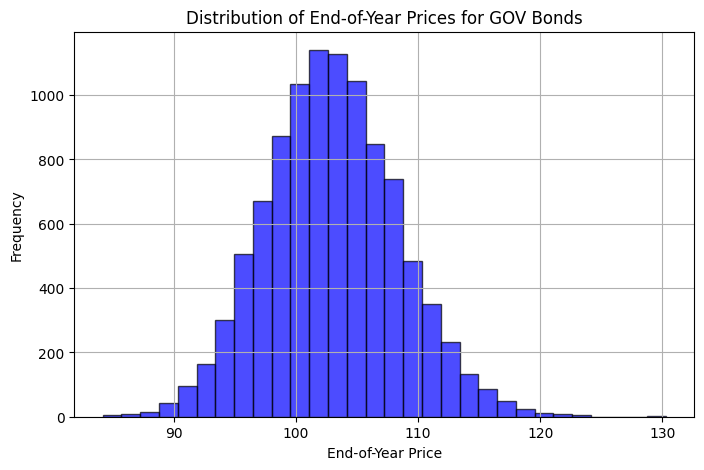

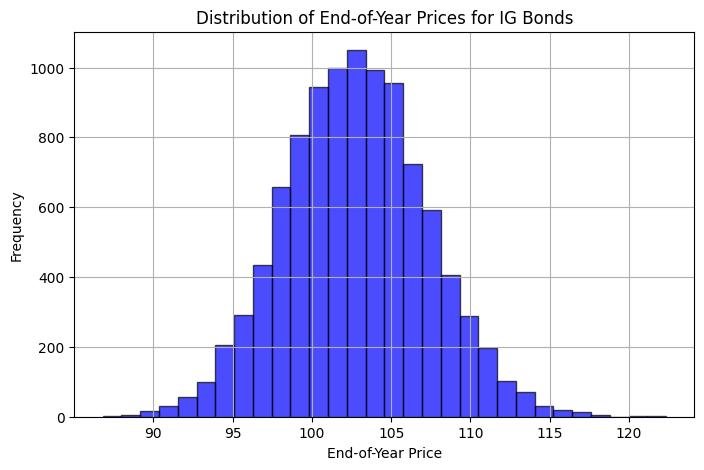

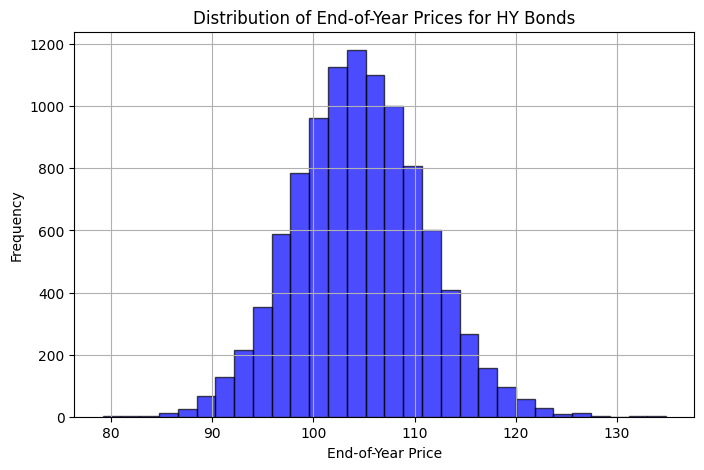

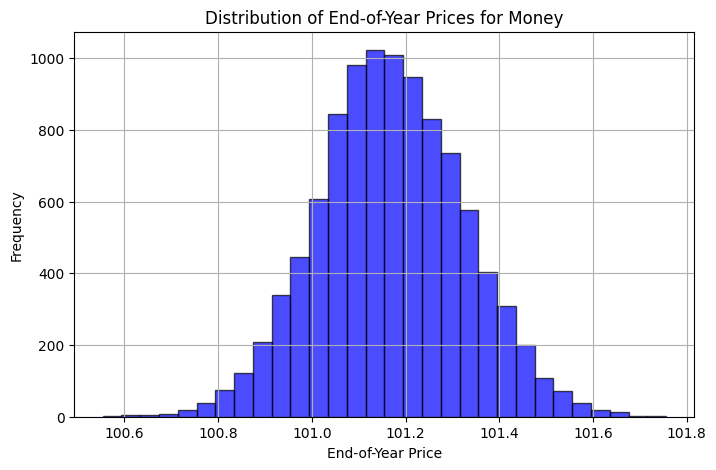

In [12]:
end_prices = pd.DataFrame({i: simulated_results[i].iloc[-1] for i in range(n_realizations)}).T

for asset in returns_df.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(end_prices[asset], bins=30, alpha=0.7,
             color='blue', edgecolor='black')
    plt.xlabel("End-of-Year Price")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of End-of-Year Prices for {asset}")
    plt.grid(True)
    plt.show()

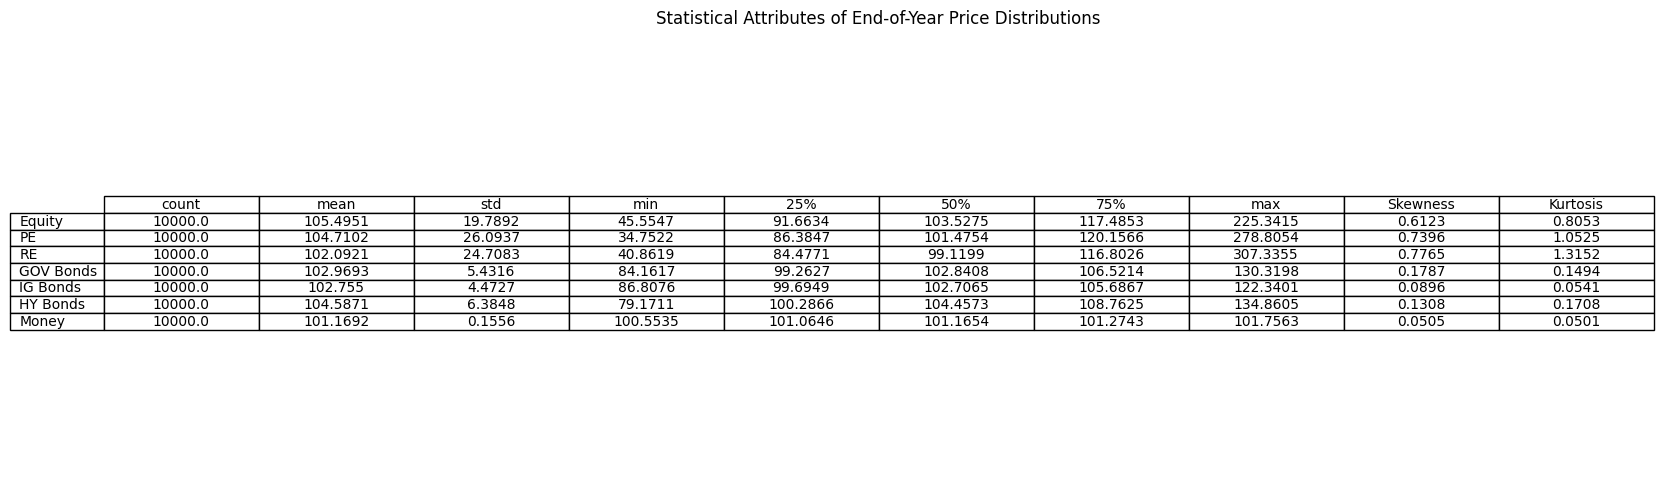

In [13]:
stats_summary = end_prices.describe().T  # Transpose to match asset-wise format

# Add skewness and kurtosis
stats_summary["Skewness"] = end_prices.skew()
stats_summary["Kurtosis"] = end_prices.kurtosis()

# Display the summary statistics
import matplotlib.pyplot as plt
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

tbl = table(ax, stats_summary.round(4), loc='center', cellLoc='center', colWidths=[0.2] * len(stats_summary.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)

plt.title("Statistical Attributes of End-of-Year Price Distributions", fontsize=12)
plt.show()

### Now, finding the 99.5% VaR of equally weighted portfolio of these assets

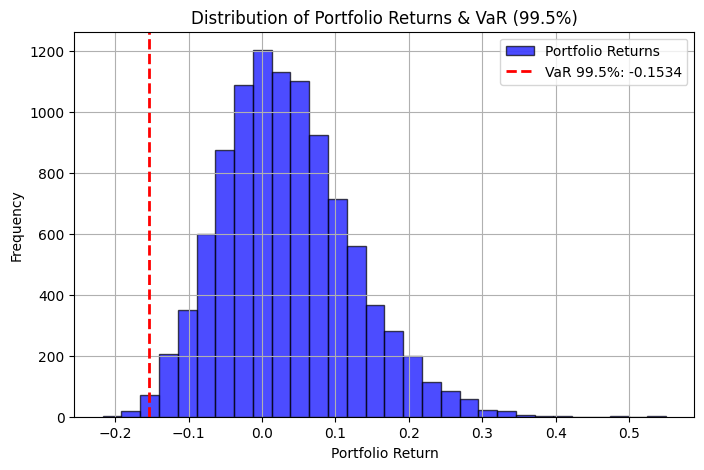

np.float64(-0.15335857146955142)

In [14]:
initial_investment = 100
weights = np.ones(len(returns_df.columns)) / len(returns_df.columns)  

portfolio_end_values = end_prices.dot(weights)

portfolio_returns = (portfolio_end_values - initial_investment) / initial_investment

var_995 = np.percentile(portfolio_returns, 0.5)  


plt.figure(figsize=(8, 5))
plt.hist(portfolio_returns, bins=30, alpha=0.7, color='blue', edgecolor='black', label="Portfolio Returns")
plt.axvline(var_995, color='red', linestyle='dashed', linewidth=2, label=f"VaR 99.5%: {var_995:.4f}")
plt.xlabel("Portfolio Return")
plt.ylabel("Frequency")
plt.title("Distribution of Portfolio Returns & VaR (99.5%)")
plt.legend()
plt.grid(True)
plt.show()

var_995